In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import random

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('GPU available',torch.cuda.is_available())
random.seed(1234)


System Version: 3.10.13 (main, Feb 26 2024, 19:58:12) [GCC 11.4.0]
PyTorch version 2.2.1+cu121
Torchvision version 0.17.1+cu121
Numpy version 1.25.2
Pandas version 2.2.1
GPU available True


In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None) -> None:
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] 

    @property
    def classes(self):
        return self.data.classes


In [3]:
data_dir = '../image_dataset/train'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
dataset = PlayingCardDataset(data_dir=data_dir, transform=transform)
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [4]:
len(dataset)

7624

In [5]:
image, label = dataset[6000]
print(label)
image

41


tensor([[[0.9843, 0.9882, 0.9961,  ..., 0.9255, 0.9451, 0.9529],
         [0.9922, 0.9922, 0.9961,  ..., 0.8902, 0.9059, 0.9137],
         [1.0000, 0.9961, 0.9882,  ..., 0.8510, 0.8627, 0.8667],
         ...,
         [0.9961, 0.9922, 0.9843,  ..., 0.8784, 0.8706, 0.8667],
         [0.9922, 0.9882, 0.9922,  ..., 0.8745, 0.8667, 0.8627],
         [0.9882, 0.9882, 0.9961,  ..., 0.8745, 0.8667, 0.8627]],

        [[0.9843, 0.9882, 0.9961,  ..., 0.9255, 0.9451, 0.9529],
         [0.9922, 0.9922, 0.9961,  ..., 0.8902, 0.9098, 0.9176],
         [1.0000, 0.9961, 0.9882,  ..., 0.8549, 0.8667, 0.8706],
         ...,
         [0.9961, 0.9922, 0.9882,  ..., 0.8824, 0.8745, 0.8706],
         [0.9922, 0.9882, 0.9922,  ..., 0.8784, 0.8706, 0.8667],
         [0.9882, 0.9882, 0.9961,  ..., 0.8784, 0.8706, 0.8667]],

        [[0.9843, 0.9882, 0.9961,  ..., 0.9098, 0.9373, 0.9451],
         [0.9922, 0.9922, 0.9961,  ..., 0.8745, 0.8941, 0.9020],
         [1.0000, 0.9961, 0.9882,  ..., 0.8353, 0.8471, 0.

In [6]:
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [7]:
# iterate over dataset
for image, label in dataset:
    break


# Dataloaders
- Batching our dataset

In [8]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
for images, labels in dataloader:
    break

In [10]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [11]:
labels

tensor([ 0, 46, 14, 11, 13,  7,  6, 24, 38, 15, 39,  3, 36,  6, 25,  6, 22, 14,
         1,  3, 35, 33, 44, 24, 48, 43, 10, 42, 30, 21, 11,  0])

# Step 2. Pytorch Model

In [12]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes = 53) -> None:
        super(SimpleCardClassifier, self).__init__()
        # Where we define all the parts of the model.
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size, num_classes)


    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        return self.classifier(x)

In [13]:
model = SimpleCardClassifier(num_classes=53)

In [14]:
print(model)

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, ke

In [15]:
example_out = model(images)
print(example_out)
example_out.shape # [batch_size, num_classes]

tensor([[-0.0673,  0.1112,  0.2850,  ...,  0.0648, -0.2538, -0.1978],
        [-0.2425, -0.0176, -0.1353,  ...,  0.3626,  0.0579,  0.3115],
        [-0.1387, -0.3324,  0.1511,  ...,  0.3559,  0.1153, -0.1081],
        ...,
        [-0.1072,  0.1713,  0.1028,  ...,  0.1106,  0.3347, -0.1539],
        [ 0.2445, -0.2658,  0.4365,  ...,  0.2538,  0.5439, -0.4636],
        [ 0.1061,  0.2226, -0.1700,  ...,  0.0534, -0.0306, -0.6584]],
       grad_fn=<AddmmBackward0>)


torch.Size([32, 53])

# Step 3. The training loop

In [16]:
# Loss function
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
criterion(example_out, labels)

tensor(4.0298, grad_fn=<NllLossBackward0>)

In [18]:
train_folder = '../image_dataset/train'
valid_folder = '../image_dataset/valid'
test_folder = '../image_dataset/test'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


train_dataset = PlayingCardDataset(train_folder, transform=transform)
valid_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
num_epochs = 20
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")



Epoch 1/20 - Train loss: 1.5857245076490725, Validation loss: 0.4210105756543717
Epoch 2/20 - Train loss: 0.580286413274807, Validation loss: 0.18061255936352713
Epoch 3/20 - Train loss: 0.36459403974468285, Validation loss: 0.3399197573931712
Epoch 4/20 - Train loss: 0.2676347581687279, Validation loss: 0.1371175876203573
Epoch 5/20 - Train loss: 0.1881701402241073, Validation loss: 0.23691124691153473
Epoch 6/20 - Train loss: 0.15759646017905735, Validation loss: 0.2415400118198035
Epoch 7/20 - Train loss: 0.1306338175185267, Validation loss: 0.15781786486787616
Epoch 8/20 - Train loss: 0.1254849210948315, Validation loss: 0.10998219167286495
Epoch 9/20 - Train loss: 0.1344459387635009, Validation loss: 0.10291076867647891
Epoch 10/20 - Train loss: 0.10344397516067043, Validation loss: 0.1387789878080476
Epoch 11/20 - Train loss: 0.09958677251450913, Validation loss: 0.14881451824363673
Epoch 12/20 - Train loss: 0.07332276252703301, Validation loss: 0.14936671054588174
Epoch 13/20 - 

# Visualize Losses

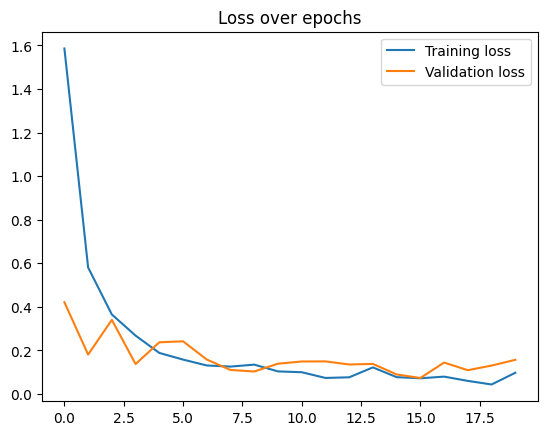

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

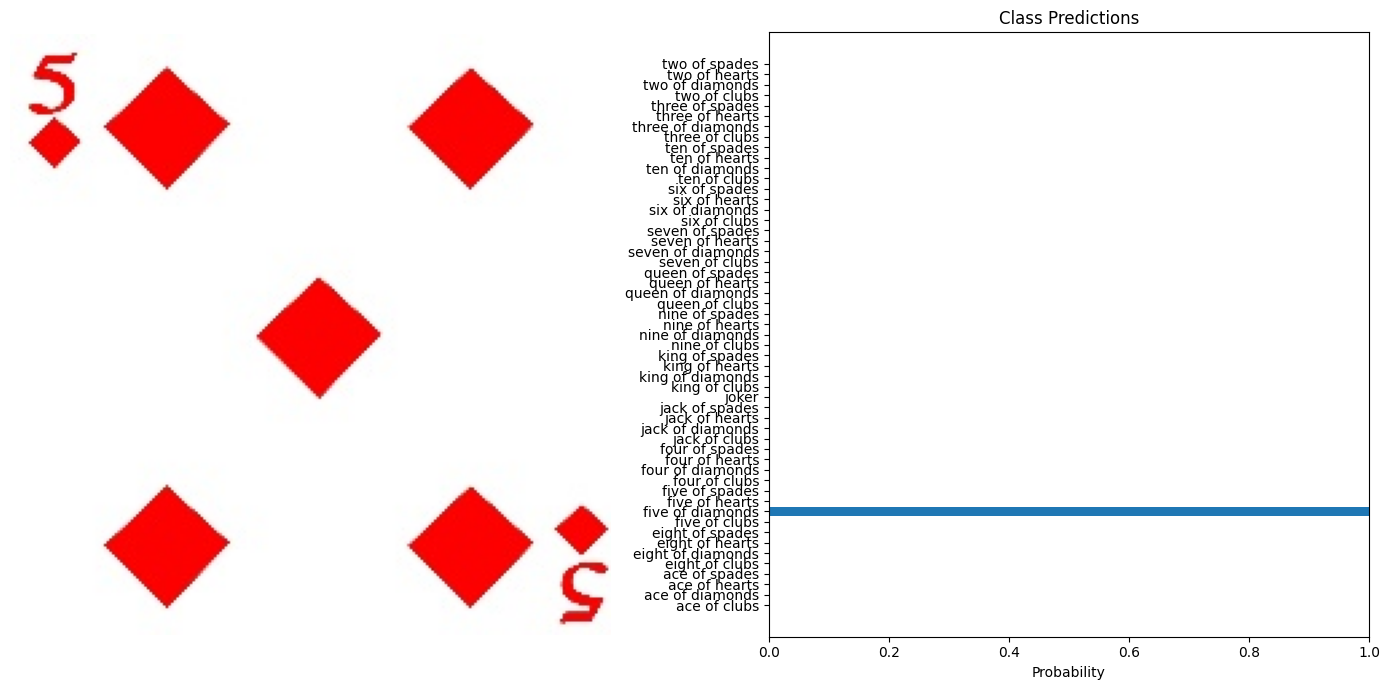

[1.39156839e-10 4.28289448e-09 1.09084713e-10 3.82161108e-10
 4.15758733e-10 5.29541389e-08 2.83326185e-09 6.55870150e-11
 3.87380084e-08 9.99996066e-01 1.93339156e-06 1.21960781e-07
 3.10924786e-10 2.92613890e-07 2.59387933e-09 2.32589725e-09
 3.20445785e-08 4.44761428e-09 5.27911215e-10 1.64085801e-09
 4.31019775e-10 7.45320861e-10 3.79025487e-08 4.29307451e-10
 7.37548633e-10 1.72644021e-09 8.82648550e-08 2.41401987e-09
 9.30627242e-10 2.98289449e-10 5.03061592e-09 4.44414366e-10
 2.22105512e-09 7.42553907e-10 7.79434288e-07 4.58755389e-09
 8.72731887e-11 1.43723278e-09 5.85786779e-08 1.43986956e-09
 1.69906395e-10 1.43836254e-09 2.34941346e-08 3.43895940e-10
 3.50905727e-09 9.78579662e-10 4.10189301e-07 4.64767891e-10
 1.66315614e-10 4.86224228e-10 4.88209384e-09 1.82968896e-09
 3.32888467e-10]
9


In [21]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "../image_dataset/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)
print(probabilities)
print(np.argmax(probabilities, axis = 0))

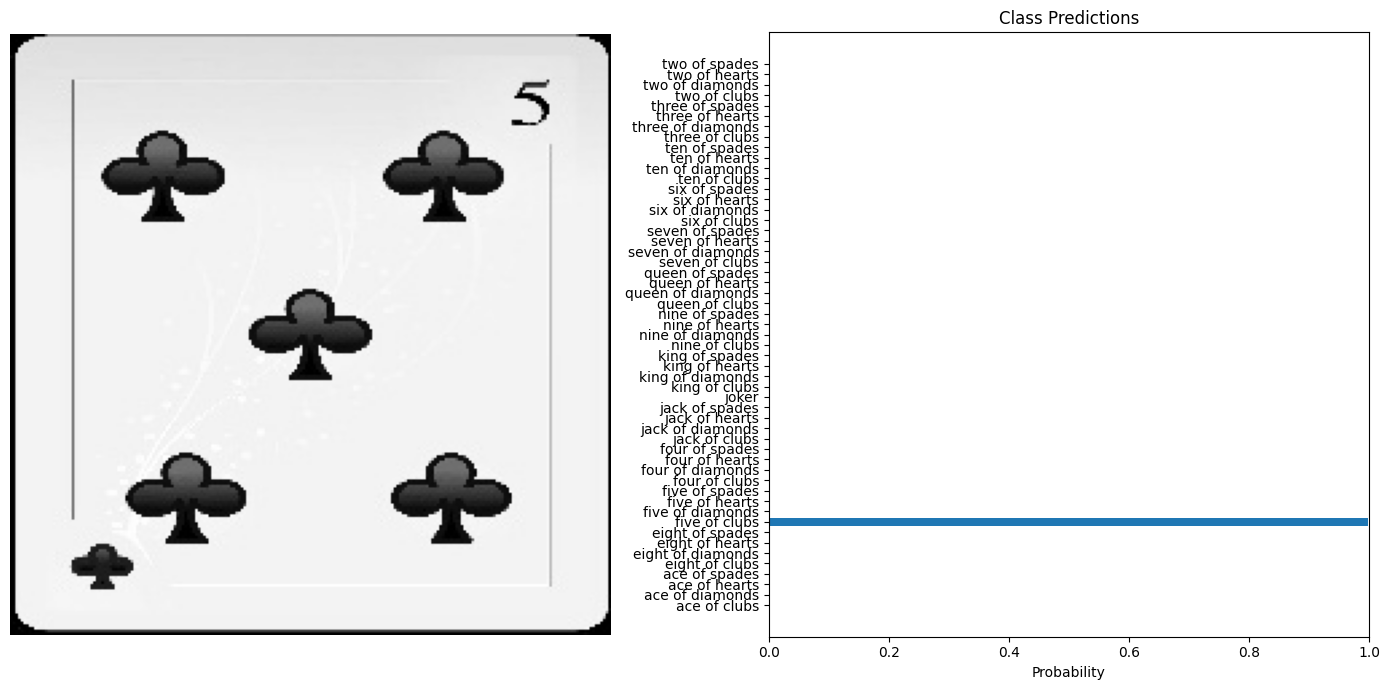

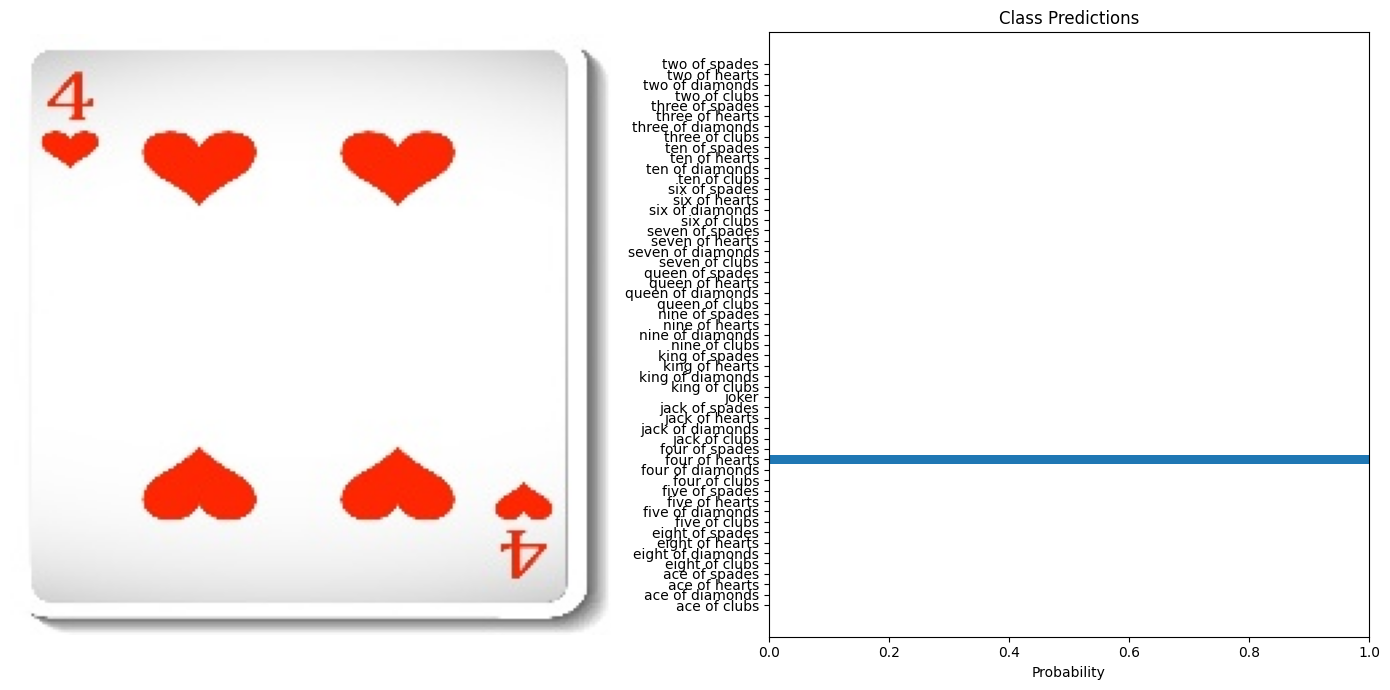

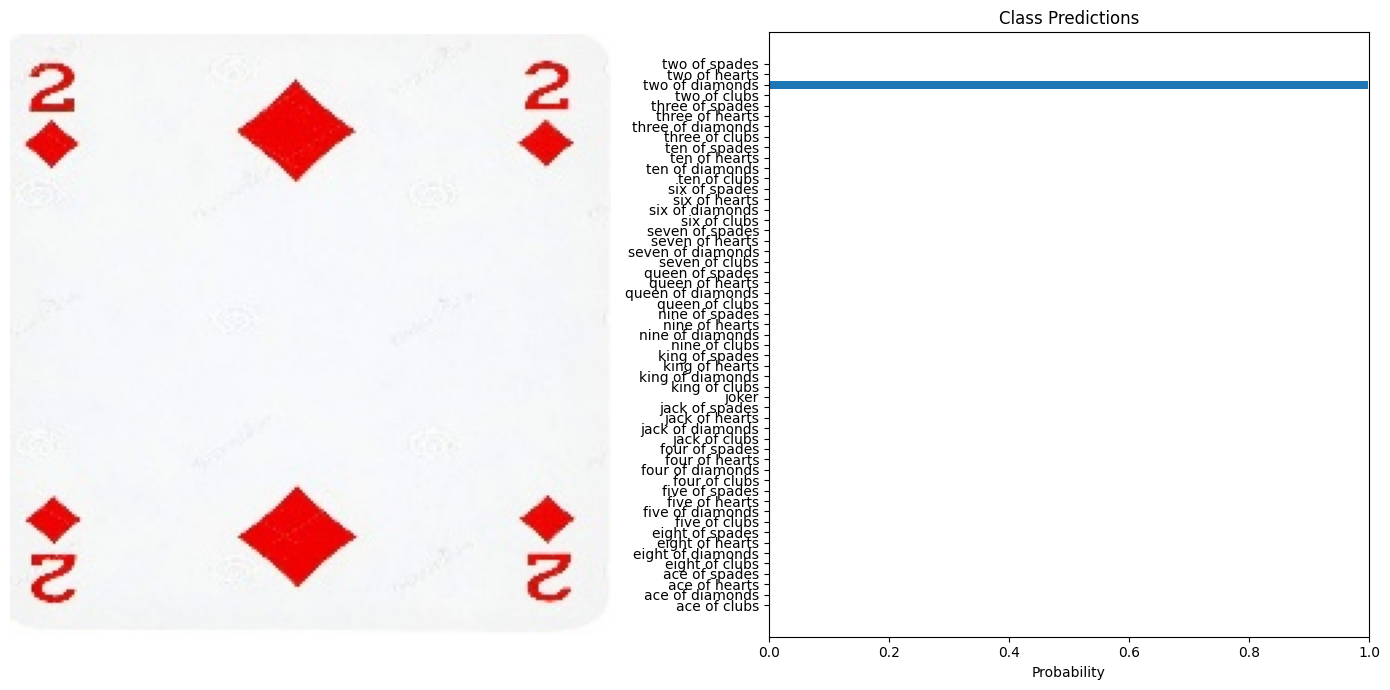

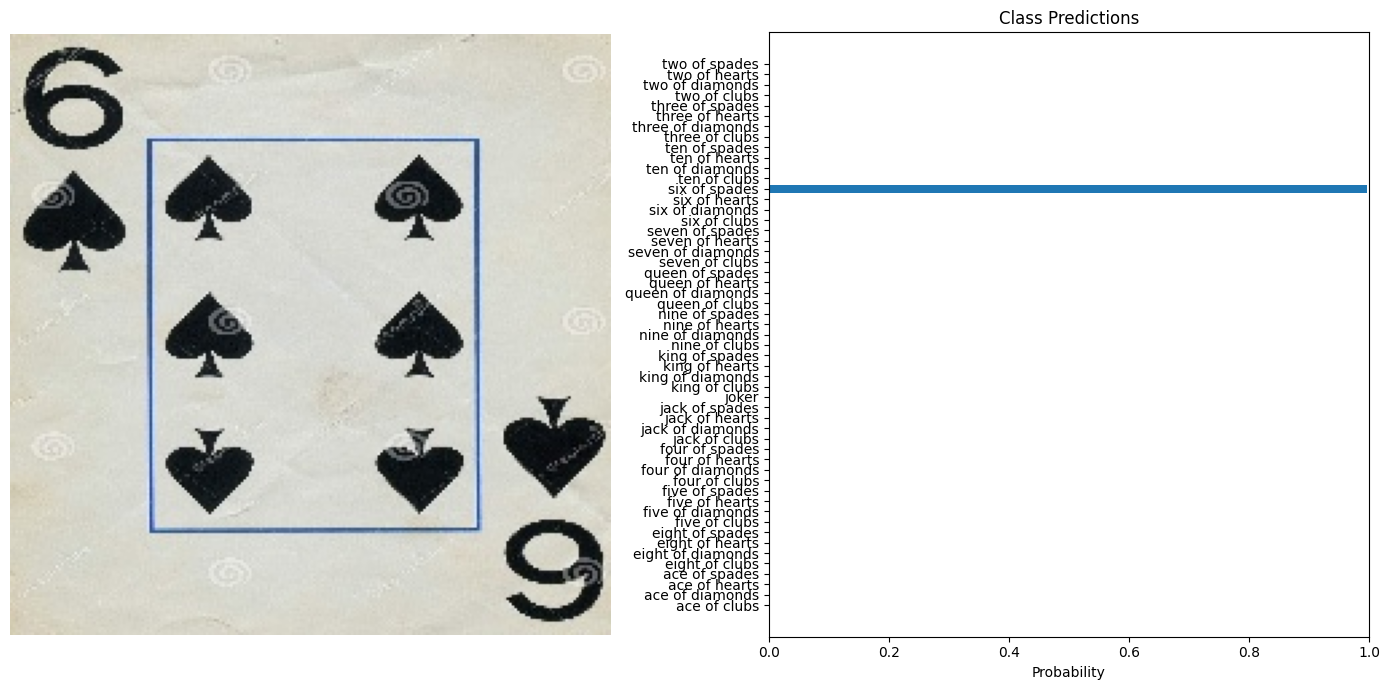

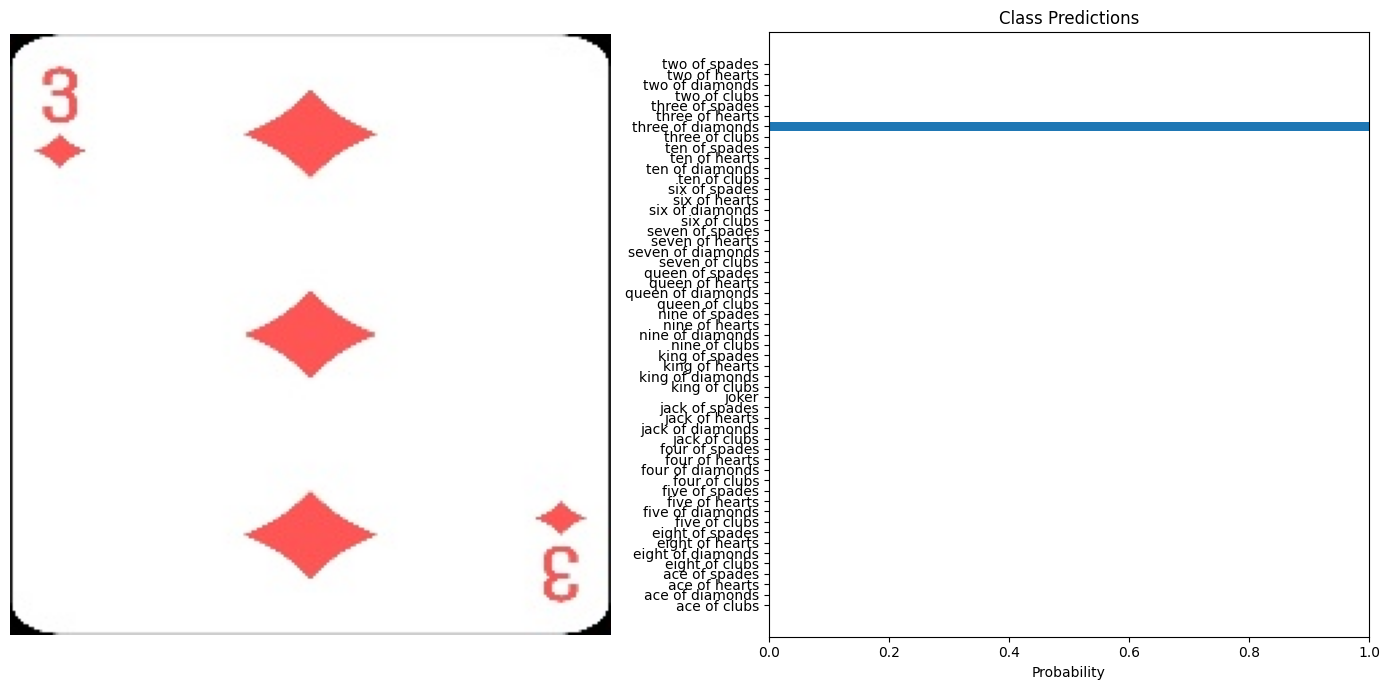

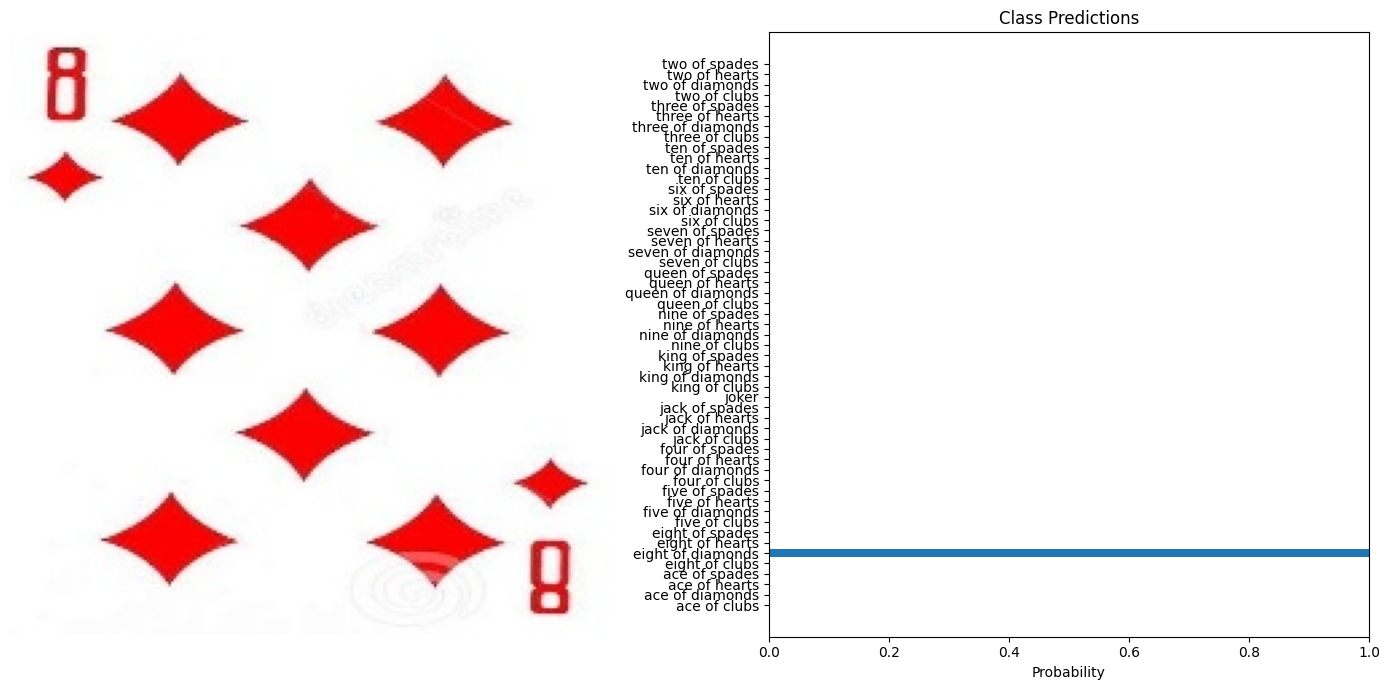

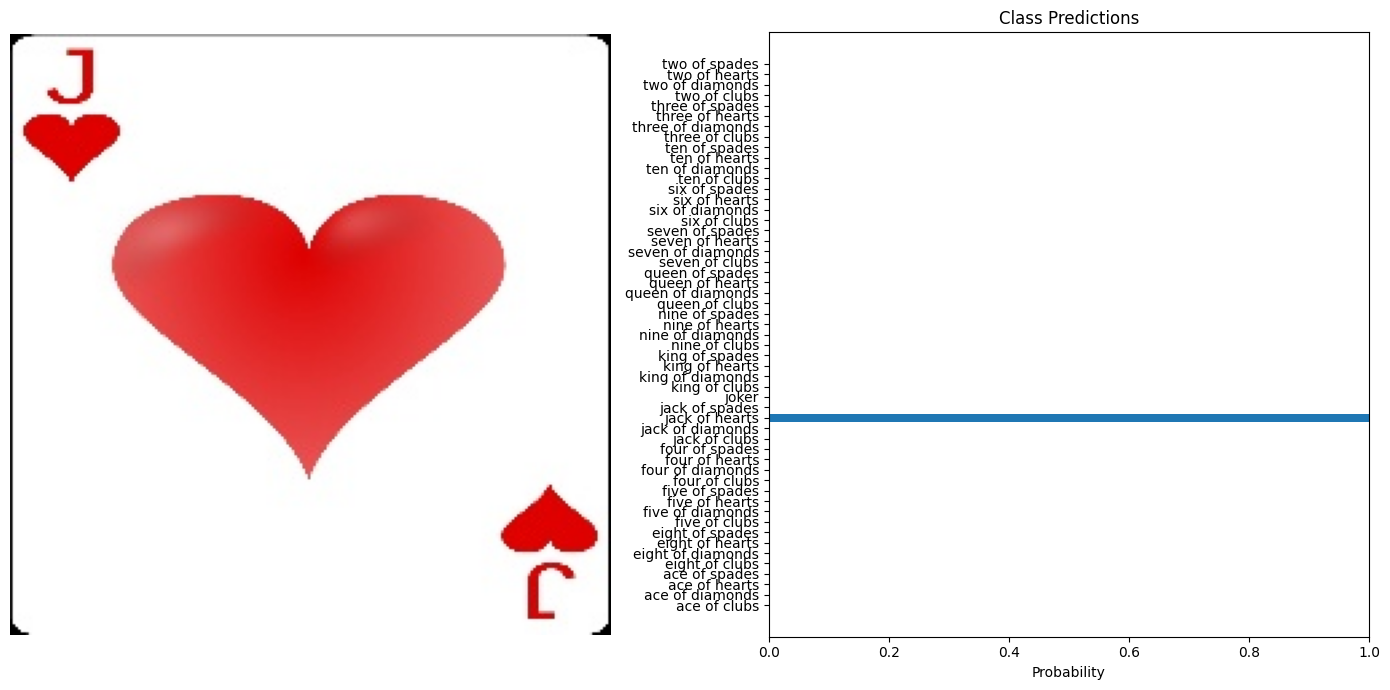

In [22]:
from glob import glob
test_images = glob('../image_dataset/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_true = []
y_pred = []

def batch_predict(model, images, device):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probabilities = nn.functional.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
 
    return predictions.cpu().numpy().flatten()

for images, labels in test_loader:
    predictions = batch_predict(model, images, device)
    y_true.extend(list(labels.cpu().numpy().flatten()))
    y_pred.extend(list(predictions))

# confusion_matrix(y_true, y_pred)
accuracy_score(y_true, y_pred)




0.9509433962264151